# Functionalizing the SINDy-SHRED pipeline

Check out SINDy-SHRED fits for ENSO signals.

In [1]:
import glob
import os
import random
import sys
import warnings

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import driver as model_driver
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysindy as ps

# netcdf/numpy/xray/stats
import scipy

# import plotting
import seaborn as sns
import sindy
import sindy_shred
import torch
import xarray as xr
from pysindy.differentiation import FiniteDifference

warnings.filterwarnings("ignore")

# Load data

In [2]:
# Adjust these to your paths
dir_hadisst_data = os.path.join(
    "/Users/karllapo/Library/CloudStorage/Dropbox/ESPRIT/proj/data/climate/HadISST/"
)
dir_print = os.path.join(
    "/Users/karllapo/Library/CloudStorage/Dropbox/ESPRIT/proj/notebooks/sindy-shred/sindy-shred/figures/HadISST"
)
dir_results = os.path.join(
    "/Users/karllapo/Dropbox/ESPRIT/proj/notebooks/mrdmd/PNAS figures/results/HadISST"
)

# Load the HadISST data
ds_obs = xr.open_dataset(
    os.path.join(dir_hadisst_data, "HadISST_sst.analysis-subset.nc"), engine="h5netcdf"
)
data_name = "HadISST-subset"

t1 = pd.Timestamp(ds_obs.time.values[0])
t1 = t1.replace(hour=0)
t1 = t1.replace(second=0)
t1 = t1.replace(minute=0)
t1 = t1.replace(microsecond=0)

t2 = pd.Timestamp(ds_obs.time.values[-1])
t2 = t2.replace(hour=0)
t2 = t2.replace(second=0)
t2 = t2.replace(minute=0)
t2 = t2.replace(microsecond=0)

# Create an even 30 day sample instead of monthly
even_time = pd.date_range(start=t1, end=t2, freq="30d")
ds_obs = ds_obs.interp(time=even_time)

# The interpolation causes the first time step to be dropped due to being out of the time bounds.
ds_obs = ds_obs.dropna(how="all", dim="time")

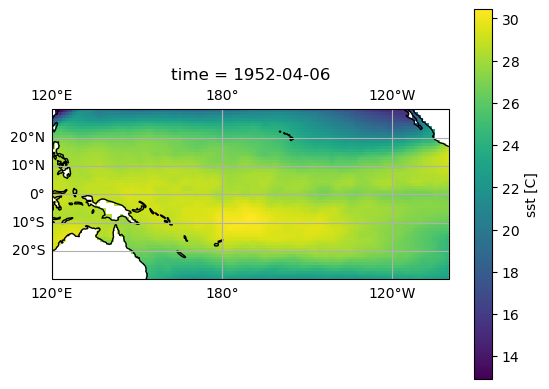

In [3]:
# define CRS's for our use case
crs0 = ccrs.PlateCarree(
    central_longitude=0
)  # for coding data, same as ccrs.PlateCarree()
crs180 = ccrs.PlateCarree(central_longitude=180)  # for plotting map in pacific area

# For all plotting, use `crs180`
fig, paco_region = plt.subplots(subplot_kw={"projection": crs180})

p = ds_obs.sst.isel(time=1000).plot(
    ax=paco_region,
    transform=crs0,  # the data's projection
)
paco_region.gridlines(crs=crs0, draw_labels=True)
paco_region.set_extent([120, 260, -30, 30], crs=crs0)
paco_region.add_feature(cfeature.COASTLINE)

## Prepare data for fitting

In [4]:
# Get the properties of a single snapshot, specifically the portion of the data not masked by land.
data_snapshot = ds_obs.sst.isel(time=0).values
ind_lat, ind_lon = np.where(~np.isnan(data_snapshot))
n_space = len(ind_lat)
n_time = len(ds_obs.time)

longitudes_ragged = ds_obs.longitude.isel(longitude=ind_lon)
latitudes_ragged = ds_obs.latitude.isel(latitude=ind_lat)

ds_obs["sst"] = ds_obs.sst.transpose("longitude", "latitude", "time")
data_3d = ds_obs.sst.values

data_1d = data_3d.reshape(
    ds_obs.longitude.size * ds_obs.latitude.size, ds_obs.time.size
)
nandex_1d = np.nonzero(np.isnan(data_1d))
notnandex_1d = np.nonzero(~np.isnan(data_1d))

data_to_fit = data_1d[notnandex_1d]
data_to_fit = data_to_fit.reshape(n_space, n_time)

print(data_to_fit.shape)

(7815, 1854)


In [5]:
# Convert time to days
ts = ds_obs.time
ts = ts - ts.isel(time=0)
ts = (ts / (1e9 * 24 * 60 * 60)).values.astype(float)
# Time step in days
dt = 30

## Helpers

In [6]:
def enso_box_extract(ds, box):
    """
    Extract out data within the ENSO 3.4 box.
    """
    ds_sub = ds.where(
        (ds.latitude > box[2])
        & (ds.latitude < box[3])
        & (ds.longitude < box[1])
        & (ds.longitude > box[0]),
        drop=True,
    )

    return ds_sub


def xarray_unstacked(x, time, longitudes, latitudes):
    """
    Unstack data back to longitude by latitude.
    """
    ds_unstacked = xr.DataArray(
        x,
        coords={"time": time},
        dims=["xy", "time"],
    )

    ds_unstacked.coords["longitude"] = ("xy", longitudes.data)
    ds_unstacked.coords["latitude"] = ("xy", latitudes.data)
    ds_unstacked = ds_unstacked.set_index(xy=("latitude", "longitude")).unstack("xy")

    return ds_unstacked


def longitude_reorder(ds):
    """
    Help handle the annoying zero-line crossing that perplexes Cartopy.
    """
    ds["longitude"] = xr.where(
        ds.longitude > 0,
        ds.longitude - 180,
        ds.longitude + 180,
    )
    ds = ds.sortby(ds.longitude)
    return ds


def monthly_anomaly(ds, modern_baseline=True):
    """
    Build monthly anomalies to be consistent with the definition of ENSO3.4
    """

    if modern_baseline:
        monthly_mean = (
            ds.sel(time=slice("1991-01-01", "2020-01-01")).groupby("time.month").mean()
        )

    ds_monthly_anomaly = ds.groupby("time.month") - monthly_mean
    ds_monthly_anomaly = ds_monthly_anomaly.rolling(time=3, center=True).mean()

    return ds_monthly_anomaly


def plot_enso_box(ax, enso_box):
    """
    Plot the ENSO 3.4 box on a cartopy map.
    """
    ax.add_patch(
        mpatches.Rectangle(
            xy=[enso_box[0], enso_box[2]],
            width=50,
            height=10,
            facecolor="none",
            edgecolor="k",
            transform=crs180,
            zorder=10,
        ),
    )


def add_grid_lines(ax, no_bottom_labels=False, label_kwargs=None):
    """
    Add grid lines to a cartopy map.
    """

    if label_kwargs is None:
        label_kwargs = {"fontsize": 7}

    gl = ax.gridlines(crs=crs180, draw_labels=True)
    if not ax.axes.get_subplotspec().is_first_col():
        gl.left_labels = False
    if no_bottom_labels:
        gl.bottom_labels = False
    gl.top_labels = False
    gl.right_labels = False
    gl.xlines = False
    gl.ylines = False
    gl.xlabel_style = label_kwargs
    gl.ylabel_style = label_kwargs

    ax.set_extent([120, 260, -30, 30], crs=crs0)
    ax.add_feature(cfeature.COASTLINE)

## Build Oceanic El Nino Index (ONI)

In [7]:
enso34_box = [-170, -120, -5, 5]

ds_obs_enso = enso_box_extract(ds_obs.sst, enso34_box)
ds_reference = ds_obs_enso.sel(
    time=slice(pd.Timestamp("1991-01-01"), pd.Timestamp("2020-12-31"))
)
reference_baseline = (
    ds_reference.mean(dim=["latitude", "longitude"]).groupby("time.month").mean()
)

background_total_mean = ds_obs_enso.mean(dim=["latitude", "longitude"])
background_total_mean = (
    background_total_mean.sel(time=slice("1991-01-01", "2020-12-31"))
    .groupby("time.month")
    .mean()
)

background_spatial_mean = ds_obs_enso.mean(dim=["latitude", "longitude"]).groupby(
    "time.month"
)
background_anomaly = background_spatial_mean - background_total_mean

# This is now the ONI
background_anomaly = background_anomaly.rolling(time=3, center=True).mean()

In [8]:
background_monthly = ds_obs_enso.groupby("time.month")
background_total_mean = ds_reference.mean(dim=["latitude", "longitude"])
background_total_mean = background_total_mean.groupby("time.month").mean()

# This is the ONI but without the spatial averaging
ds_oni = background_monthly - background_total_mean
ds_oni = ds_oni.rolling(time=3, center=True).mean().dropna(dim="time", how="any")

Create an ONI for fitting in SINDy-SHRED

In [9]:
oni_snapshot = ds_oni.isel(time=0).values
ind_lon, ind_lat = np.where(~np.isnan(oni_snapshot))
n_space_oni = len(ind_lat)
n_time_oni = len(ds_oni.time)

lon_ragged_oni = ds_oni.longitude.isel(longitude=ind_lon)
lat_ragged_oni = ds_oni.latitude.isel(latitude=ind_lat)

oni_3d = ds_oni.values

oni_1d = oni_3d.reshape(ds_oni.longitude.size * ds_oni.latitude.size, ds_oni.time.size)
nandex_1d = np.nonzero(np.isnan(oni_1d))
notnandex_1d = np.nonzero(~np.isnan(oni_1d))

oni_to_fit = oni_1d[notnandex_1d]
oni_to_fit = oni_to_fit.reshape(n_space_oni, n_time_oni)

print(oni_to_fit.shape)

(500, 1852)


# Scale-aware SINDy-SHRED

In [10]:
# Set this BEFORE importing torch if you need to control GPU access
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Choose device
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

# Set seeds for reproducibility
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

# Optional: CUDA-specific seed (only if using CUDA)
if device == "cuda":
    torch.cuda.manual_seed(0)

# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

We now select indices to divide the data into training, validation, and test sets.

# SINDy-SHRED

## Specify data to fit

In [11]:
modes_to_fit = "ONI"

# We will select a subset of the data, in this case starting in the modern period.
# t_ind = slice(80 * 12, None)  # From ~1950 to present
t_ind = slice(128 * 12, None)  # From ~2006 to present

if modes_to_fit == "original":
    lags = np.round(365 / dt).astype(int)
    scale_aware_data = data_to_fit[:, t_ind]
    num_train_years = 10
    num_test_years = 5
    num_validate_years = 0.5

elif modes_to_fit == "ONI":
    lags = 24
    scale_aware_data = oni_to_fit[:, t_ind]
    num_train_years = 10
    num_test_years = 5
    num_validate_years = 0.01

ts_sindy_shred = ts[t_ind]
ts_physical = ds_obs.time[t_ind]

num_sensors = 500
load_X = scale_aware_data.T
len_t = load_X.shape[0]  # time dimension length
len_space = load_X.shape[1]  # space dimension length

sensor_locations = np.random.choice(len_space, size=num_sensors, replace=False)

train_length = np.round(num_train_years * 365 / dt).astype(int)
validate_length = np.round(num_validate_years * 365 / dt).astype(int)
test_length = np.round(num_test_years * 365 / dt).astype(int)

Check out the data and data splits to make sure they make sense.

(0.0, 183.0)

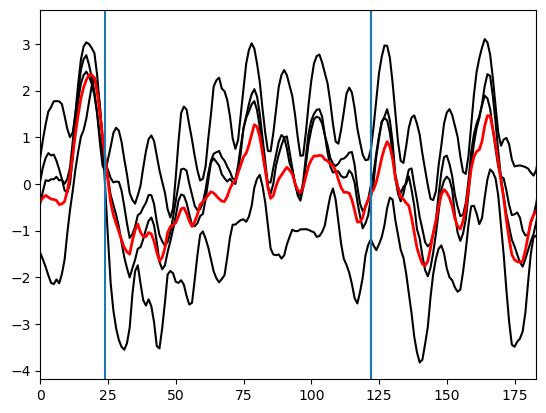

In [12]:
s = scale_aware_data.shape[0]
for n in [0, s // 4, s // 2, int(s // 4 * 3)]:
    plt.plot(scale_aware_data[n], color="k")

plt.plot(scale_aware_data.mean(axis=0), color="r", lw=2)
plt.gca().axvline(train_length)
plt.gca().axvline(validate_length + train_length)
plt.gca().axvline(lags)
plt.xlim(0, train_length + validate_length + test_length)

Specify the library.

Latent dim of 12 leads to a great reconstruction of the splits. But! Posthoc model discovery doesn't seem to work very well.


In [13]:
latent_dim = 12
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)

## Fit the Model

In [14]:
# Set seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

driver = model_driver.sindy_shred_driver(
    latent_dim=latent_dim,
    poly_order=poly_order,
    verbose=True,
    # It really needs the extra training time from 2000
    num_epochs=1000,
    threshold=0.000,
    sample_mode="forecast",
    batch_size=32,
    sindy_regularization=1.0,
)
driver.fit(
    num_sensors,
    dt,
    load_X,
    lags,
    train_length,
    validate_length,
    sensor_locations,
    test_length=test_length,
    seed=1,
)

1 : tensor(0.1222, device='mps:0', grad_fn=<AddBackward0>)
2 : tensor(0.0628, device='mps:0', grad_fn=<AddBackward0>)
3 : tensor(0.0437, device='mps:0', grad_fn=<AddBackward0>)
4 : tensor(0.0382, device='mps:0', grad_fn=<AddBackward0>)
5 : tensor(0.0329, device='mps:0', grad_fn=<AddBackward0>)
6 : tensor(0.0265, device='mps:0', grad_fn=<AddBackward0>)
7 : tensor(0.0195, device='mps:0', grad_fn=<AddBackward0>)
8 : tensor(0.0146, device='mps:0', grad_fn=<AddBackward0>)
9 : tensor(0.0144, device='mps:0', grad_fn=<AddBackward0>)
10 : tensor(0.0142, device='mps:0', grad_fn=<AddBackward0>)
11 : tensor(0.0113, device='mps:0', grad_fn=<AddBackward0>)
12 : tensor(0.0118, device='mps:0', grad_fn=<AddBackward0>)
13 : tensor(0.0121, device='mps:0', grad_fn=<AddBackward0>)
14 : tensor(0.0111, device='mps:0', grad_fn=<AddBackward0>)
15 : tensor(0.0108, device='mps:0', grad_fn=<AddBackward0>)
16 : tensor(0.0097, device='mps:0', grad_fn=<AddBackward0>)
17 : tensor(0.0102, device='mps:0', grad_fn=<AddB

## Posthoc model discovery

The following code block extracts latent states using a GRU model. Each of the first three dimensions is normalized and re-scaled to [-1,1]. A SINDy model is then set up with a polynomial library. This SINDy model is fitted to the data and later used to simulate the dynamics for comparison with the original GRU latent trajectories.

The hyperparameters for the SINDy model are set as follows:
- **Differentiation Method:** Finite difference is used to compute numerical derivatives. When the latent states trajectories are noisy, one should consider to use ps.differentiation.SmoothedFiniteDifference().
- **Optimizer Sequantially thresholded least-squares: STLSQ:**  
  - *Threshold:* 0.8, which controls the sparsity level by eliminating coefficients below this value.
  - *Alpha:* 0.05, L2 regularization.
- **Optimizer Mixed-interger optimization: MIOSR:**  
  - *group_sparsity:* how many terms each equations should include. 
- **Feature Library:** Here we only include polynomial features up to degree 1, ensuring only linear terms are considered in the model. Practically this could set up to degree 3 which will include more nonlinear terms. 

For model selection, a simple baseline standard is to visually examine how the long-term extrapolation behaves. We can pick the model that fits the data well. It is also possible to include metrics (like the MSE) to quantitatively measure these quantities. 

In [149]:
# differentiation_method = "finite"
# if differentiation_method == "finite":
#     driver._differentiation_method = ps.differentiation.FiniteDifference()
# elif differentiation_method == "smoothed finite":
#     driver._differentiation_method = ps.differentiation.SmoothedFiniteDifference()

# gru_outs = driver.gru_normalize(data_type="train")
# x = gru_outs.detach().cpu().numpy()

# gru_outs = driver.gru_normalize(data_type="train")

# # SINDy discovery
# x = gru_outs.detach().cpu().numpy()
# driver._gru_outs = x

# # model = ps.SINDy(
# #     optimizer=ps.STLSQ(threshold=threshold, alpha=0.05),
# #     differentiation_method=driver._differentiation_method,
# #     feature_library=ps.PolynomialLibrary(degree=driver._poly_order),
# # )

# model = ps.SINDy(
#     optimizer=ps.MIOSR(group_sparsity=np.ones(driver._latent_dim) * 10, alpha=5000),
#     differentiation_method=driver._differentiation_method,
#     feature_library=ps.PolynomialLibrary(degree=poly_order),
# )

# model.fit(x, t=driver._dt, ensemble=True)
# driver._model = model

# print("SINDy-derived dynamical equation:\n")
# model.print()

# driver.sindy_simulate(x)
# x_sim = driver._x_sim
# t_train = np.arange(0, len(x) * driver._dt, driver._dt)
# fig, ax = plt.subplots(driver._latent_dim, sharex=True, sharey=True)
# for i in range(driver._latent_dim):
#     ax[i].plot(
#         t_train, gru_outs[:, i].detach().cpu().numpy(), label="SINDy-SHRED"
#     )
#     ax[i].plot(t_train, x_sim[:, i], "k--", label="identified model")
#     ax[i].set_ylabel(rf"$z_{{{i}}}$ (-)")
#     if i == driver._latent_dim - 1:
#         ax[i].set_xlabel("time (s)")
#         ax[i].legend()

In [150]:
# plt.hist(driver._model.coefficients().flatten(), bins=np.arange(-0.03, 0.03, 0.001));

In [151]:
# plt.pcolormesh(driver._model.coefficients(), vmin=-0.03, vmax=0.03, cmap="RdBu_r")

SINDy-derived dynamical equation:

(x0)' = 0.006 1 + -0.004 x0 + -0.012 x1 + -0.019 x2 + 0.003 x3 + -0.013 x4 + -0.007 x5 + -0.016 x6 + 0.001 x7 + -0.004 x8 + -0.004 x9 + -0.017 x10 + -0.003 x11
(x1)' = 0.007 x0 + -0.001 x1 + 0.003 x2 + -0.003 x3 + -0.001 x4 + -0.005 x5 + -0.003 x6 + 0.002 x7 + 0.002 x8 + 0.003 x9 + 0.001 x10 + 0.001 x11
(x2)' = -0.003 1 + -0.003 x0 + -0.005 x1 + -0.005 x2 + -0.002 x3 + 0.002 x4 + 0.006 x5 + -0.012 x6 + 0.008 x7 + -0.004 x8 + -0.013 x9 + 0.006 x10 + -0.003 x11
(x3)' = -0.002 1 + -0.002 x0 + -0.010 x1 + 0.001 x2 + -0.006 x3 + 0.002 x4 + -0.002 x5 + -0.004 x6 + -0.005 x7 + -0.005 x8 + -0.013 x10 + -0.004 x11
(x4)' = -0.001 1 + 0.014 x0 + 0.005 x1 + -0.005 x2 + -0.005 x3 + 0.004 x4 + -0.004 x5 + 0.003 x6 + 0.003 x7 + -0.004 x8 + -0.005 x9 + -0.005 x10 + 0.007 x11
(x5)' = 0.004 1 + -0.004 x0 + -0.003 x1 + -0.011 x2 + 0.002 x3 + -0.016 x4 + -0.008 x5 + -0.014 x6 + -0.002 x7 + -0.002 x8 + 0.001 x9 + -0.002 x10 + -0.001 x11
(x6)' = 0.002 1 + -0.003 x0 + -0.00

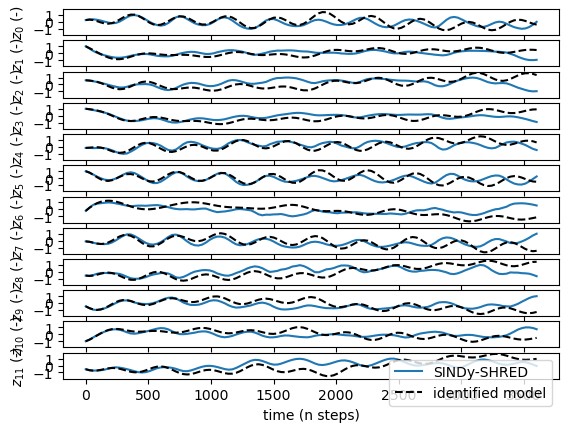

<Figure size 640x480 with 0 Axes>

In [15]:
for threshold in [0]: #[10**-6, 10**-5, 10**-4, 10**-3]:
    driver.sindy_identify(
        threshold=threshold, plot_result=True, differentiation_method="finite"
    )
    plt.gcf().suptitle(f"latent space for {modes_to_fit} mode")
    plt.gcf().tight_layout()

### Choose the model

In [16]:
# for threshold in [10**-6, 10**-5, 10**-4, 10**-3]:
# for threshold in [0]:
#     driver.sindy_identify(th|reshold=threshold, plot_result=True)
#     plt.gcf().suptitle(f"latent space for {modes_to_fit} mode")
#     plt.gcf().tight_layout()

Take coefficients and construct rxr matrix. Nathan's hypothesis: r eigenvalues with r/2 complex conjugate pairs (and maybe one DC component if r is odd). This tests if we have r/2 oscillating frequencies, as we would expect for a Koopman case. Potentially allow us to interpret these terms in place of the posthoc discovery and that we have a small number of linear oscillators.

# Evaluate

## Train-Validate-Test splits

In [17]:
train_recons = driver._scaler.inverse_transform(
    driver._shred(driver._train_data.X).detach().cpu().numpy()
)
train_ground_truth = driver._scaler.inverse_transform(
    driver._train_data.Y.detach().cpu().numpy()
)
print(
    np.linalg.norm(train_recons - train_ground_truth)
    / np.linalg.norm(train_ground_truth)
)
train_recons.shape

0.061703462


(122, 500)

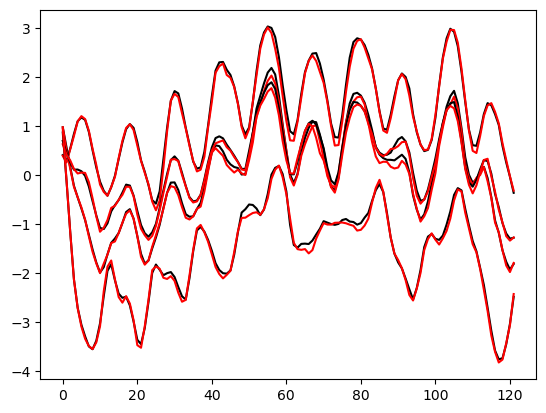

In [18]:
for n in [0, s // 4, s // 2, int(s // 4 * 3)]:
    plt.plot(train_recons[:, n], color="k")
    plt.plot(train_ground_truth[:, n], color="r")

In [19]:
# val_recons = driver._scaler.inverse_transform(
#     driver._shred(driver._valid_data.X).detach().cpu().numpy()
# )
# val_ground_truth = driver._scaler.inverse_transform(
#     driver._valid_data.Y.detach().cpu().numpy()
# )
# print(np.linalg.norm(val_recons - val_ground_truth) / np.linalg.norm(val_ground_truth))
# val_recons.shape

In [20]:
# for n in [0, s // 4, s // 2, int(s // 4 * 3)]:
#     plt.plot(val_recons[:, n], color="k")
#     plt.plot(val_ground_truth[:, n], color="r")

In [21]:
test_recons = driver._scaler.inverse_transform(
    driver._shred(driver._test_data.X).detach().cpu().numpy()
)
test_ground_truth = driver._scaler.inverse_transform(
    driver._test_data.Y.detach().cpu().numpy()
)
print("error for 1 year out of sample reconstruction")
print(
    np.linalg.norm(test_recons[0:12] - test_ground_truth[0:12])
    / np.linalg.norm(test_ground_truth[0:12])
)
test_recons.shape

error for 1 year out of sample reconstruction
0.1569559


(61, 500)

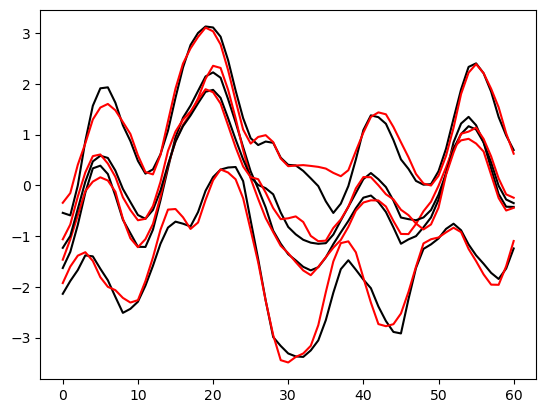

In [22]:
for n in [0, s // 4, s // 2, int(s // 4 * 3)]:
    plt.plot(test_recons[:, n], color="k")
    plt.plot(test_ground_truth[:, n], color="r")

## Compare in ENSO34 Box

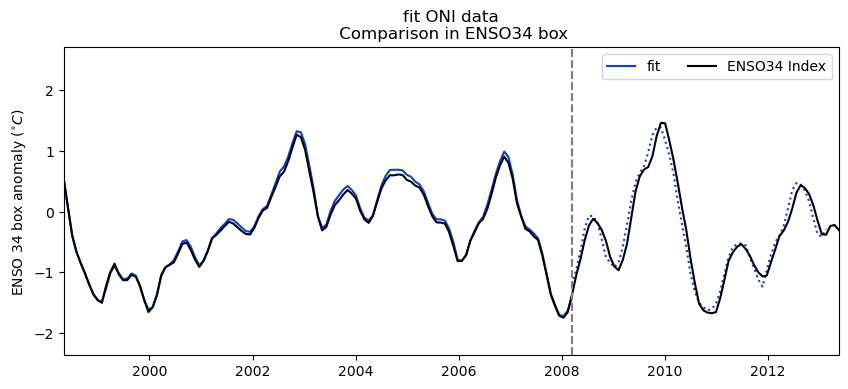

In [23]:
if modes_to_fit == "ONI":

    time_results = ds_oni.time.values[t_ind]

    plt.figure(figsize=(10, 4))

    # Train
    ds_results = xarray_unstacked(
        train_recons.T,
        time_results[lags : train_length + lags],
        lon_ragged_oni,
        lat_ragged_oni,
    )
    enso_component = enso_box_extract(ds_results, enso34_box)
    enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])
    plt.plot(
        time_results[lags - 1 : train_length + lags - 1],
        enso_spatial_mean,
        color="xkcd:blue",
        label="fit",
    )

    # Validate
#     t = time_results[
#         lags + train_length - 1 : lags + train_length + validate_length - 1
#     ]

#     ds_results = xarray_unstacked(
#         val_recons.T,
#         t,
#         lon_ragged_oni,
#         lat_ragged_oni,
#     )
#     enso_component = enso_box_extract(ds_results, enso34_box)
#     enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])
#     plt.plot(
#         t,
#         enso_spatial_mean,
#         color="xkcd:blue",
#         ls="--",
#     )

    # Test
    t = time_results[
        lags
        + train_length
        + validate_length
        - 2 : lags
        + train_length
        + validate_length
        + test_length
        - 2
    ]
    ds_results = xarray_unstacked(
        test_recons.T,
        t,
        lon_ragged_oni,
        lat_ragged_oni,
    )
    enso_component = enso_box_extract(ds_results, enso34_box)
    enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])
    plt.plot(
        t,
        enso_spatial_mean,
        color="xkcd:blue",
        ls=":",
    )

    # Observations
    plt.plot(
        background_anomaly.time, background_anomaly, color="k", label="ENSO34 Index"
    )

    plt.xlim(
        time_results[lags],
        time_results[train_length + validate_length + test_length + lags],
    )
    plt.xlim(time_results[lags], None)
    plt.legend(ncols=3)
    plt.ylabel("ENSO 34 box anomaly ($^{\circ}C$)")
    plt.gca().axvline(time_results[train_length + lags - 2], ls="--", color="0.5")
    plt.gca().axvline(
        time_results[train_length + validate_length + lags - 2], ls="--", color="0.5"
    )
    plt.title(f"fit {modes_to_fit} data\n Comparison in ENSO34 box")

In [24]:
if not modes_to_fit == "ONI":
    time_results = ds_obs.time.values[t_ind]

    plt.figure(figsize=(6, 3))

    # Train
    ds_results = xarray_unstacked(
        train_recons.T,
        time_results[lags : train_length + lags],
        longitudes_ragged,
        latitudes_ragged,
    )
    enso_component = enso_box_extract(ds_results, enso34_box)
    enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])
    plt.plot(
        time_results[lags : train_length + lags],
        enso_spatial_mean - enso_spatial_mean.mean(dim="time"),
        color="xkcd:blue",
        label="SINDy-SHRED",
    )

    # Validate
    ds_results = xarray_unstacked(
        val_recons.T,
        time_results[lags + train_length : lags + train_length + validate_length],
        longitudes_ragged,
        latitudes_ragged,
    )
    enso_component = enso_box_extract(ds_results, enso34_box)
    # enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])
    plt.plot(
        time_results[lags + train_length : lags + train_length + validate_length],
        enso_spatial_mean - enso_spatial_mean.mean(dim="time"),
        color="xkcd:blue",
        ls="--",
    )

    # Test
    t = time_results[
        lags
        + train_length
        + validate_length : lags
        + train_length
        + validate_length
        + test_length
    ]
    ds_results = xarray_unstacked(
        test_recons.T,
        t,
        longitudes_ragged,
        latitudes_ragged,
    )
    enso_component = enso_box_extract(ds_results, enso34_box)
    # enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])
    plt.plot(
        t,
        enso_spatial_mean - enso_spatial_mean.mean(dim="time"),
        color="xkcd:blue",
        ls=":",
    )

    # Observations
    enso_component = enso_box_extract(ds_obs.sst, enso34_box)
    enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])
    plt.plot(
        ds_obs.time,
        enso_spatial_mean - enso_spatial_mean.mean(dim="time"),
        label="Obs",
        color="red",
    )
    plt.plot(
        background_anomaly.time, background_anomaly, color="k", label="ENSO34 Index"
    )

    plt.xlim(
        time_results[lags],
        time_results[train_length + validate_length + test_length + lags],
    )
    plt.legend(ncols=3)
    plt.ylabel("ENSO 34 box anomaly ($^{\circ}C$)")
    plt.gca().axvline(time_results[test_length], ls="--", color="0.5")
    plt.gca().axvline(time_results[test_length + validate_length], ls="--", color="0.5")
    plt.title(f"fit {modes_to_fit} data\n Comparison in ENSO34 box")

## Spatial Maps

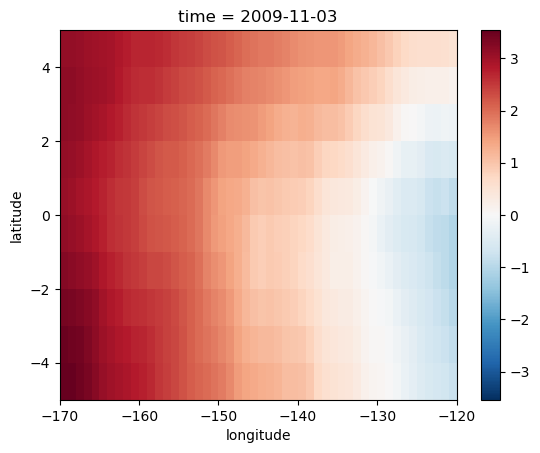

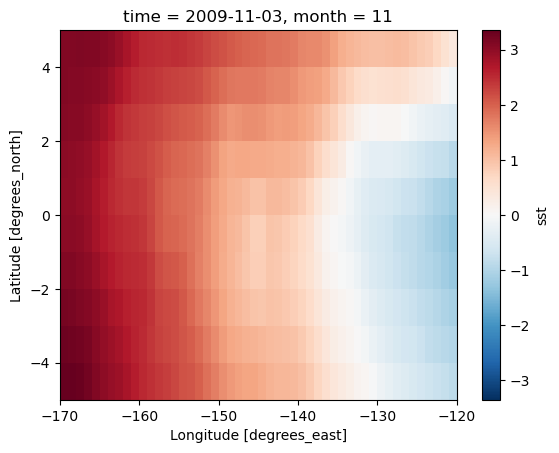

In [25]:
ds_results.sel(time="2009-11-03").plot()

plt.figure()
ds_oni.sel(time="2009-11-03").T.plot()

0.9562206410391997


Text(0.5, 1.0, 'Prediction vs Observations. Predict start = 2008-03-13, predict end = 2013-02-15')

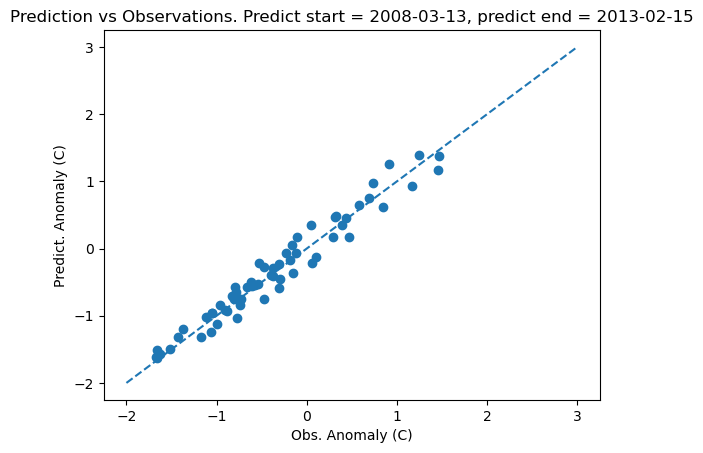

In [26]:
plt.scatter(
    background_anomaly.sel(time=slice(ds_results.time[0], ds_results.time[-1])),
    ds_results.mean(dim=["latitude", "longitude"]),
)
plt.plot([-2, 3], [-2, 3], ls="--")
plt.ylabel("Predict. Anomaly (C)")
plt.xlabel("Obs. Anomaly (C)")

r = scipy.stats.pearsonr(
    background_anomaly.sel(time=slice(ds_results.time[0], ds_results.time[-1])),
    ds_results.mean(dim=["latitude", "longitude"]),
)
print(r.correlation**2)
dt_start = pd.Timestamp(ds_results.time[0].values).strftime("%Y-%m-%d")
dt_end = pd.Timestamp(ds_results.time[-1].values).strftime("%Y-%m-%d")
plt.title(
    f"Prediction vs Observations. Predict start = {dt_start}, predict end = {dt_end}"
)

# Predict

When latent space discovery is perfect then we can closely approximate reconstruction error.

2 ways to predict:
1) unroll the LSTM (ok for short term, not great for long term)
2) integrate the discovered ODE forward

## Predict with discovered ODE model

Predict from time = 0 or from the time starting the test period?

In [27]:
# Forward simulation with the discovered SINDy model
init_cond = np.zeros(driver._latent_dim)

# t_test = np.arange(0, 365 * num_test_years, dt)
# gru_outs_test_np = driver.gru_normalize(data_type="test").detach().cpu().numpy()
# init_cond[: driver._latent_dim] = gru_outs_test_np[0, :]

t_test = np.arange(0, 365 * num_test_years, dt)
gru_outs_test_np = driver.gru_normalize(data_type="test").detach().cpu().numpy()
gru_outs_train_np = driver.gru_normalize(data_type="train").detach().cpu().numpy()
init_cond[: driver._latent_dim] = gru_outs_train_np[-1, :]

x_sim_test = driver._model.simulate(init_cond, t_test)
x_sim_test = np.array(x_sim_test)  # Ensure it's a numpy array if needed

(-1.0, 1.0)

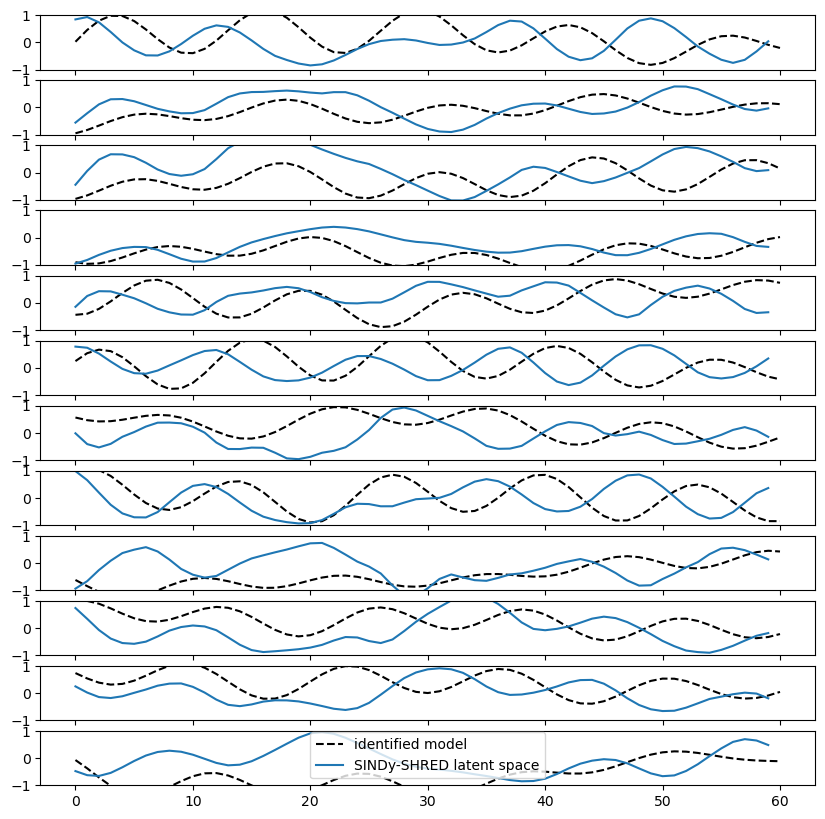

In [28]:
fig, axes = plt.subplots(
    driver._latent_dim, 1, sharex=True, sharey=True, figsize=(10, 10)
)
for n in range(driver._latent_dim):
    ax = axes[n]
    ax.plot(x_sim_test[:, n], "k--", label="identified model")
    ax.plot(gru_outs_test_np[:, n], label="SINDy-SHRED latent space")
ax.legend()
ax.set_ylim(-1, 1)

(-2.0, 2.0)

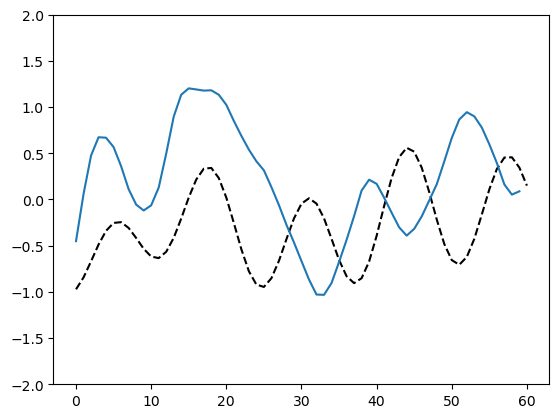

In [29]:
plt.plot(x_sim_test[:, 2], "k--")
plt.plot(gru_outs_test_np[:, 2])
plt.ylim(-2, 2)

In [30]:
# Forward simulation with the discovered SINDy model
# t_test = np.arange(0, 365 * num_test_years, dt)
# init_cond = np.zeros(driver._latent_dim)
# # init_cond[:latent_dim] = gru_outs_test_np[0, :]
# gru_outs_test_np = driver.gru_normalize(data_type="test").detach().cpu().numpy()
# init_cond[: driver._latent_dim] = gru_outs_test_np[0, :]

# x_sim_test = driver._model.simulate(init_cond, t_test)

# # Step 1: Reverse Min-Max scaling for SINDy-simulated data (x_sim_test)
# x_sim_test = np.array(x_sim_test)  # Ensure it's a numpy array if needed

# Revert the scaling from [-1, 1] back to [0, 1]
x_sim_test = (x_sim_test + 1) / 2

gru_out_train, _ = driver._shred.gru_outputs(driver._train_data.X, sindy=True)
gru_out_train = gru_out_train[:, 0, :]
gru_out_train = gru_out_train.detach().cpu().numpy()

# Perform the Min-Max reverse transformation using the original min/max values
for n in range(driver._latent_dim):  # Assuming 3 latent dimensions, need to be updated
    x_sim_test[:, n] = x_sim_test[:, n] * (
        np.max(gru_out_train[:, n]) - np.min(gru_out_train[:, n])
    ) + np.min(gru_out_train[:, n])

# Perform the decoder reconstruction using the transformed SINDy-simulated data
latent_pred_sindy = torch.FloatTensor(x_sim_test).to(
    device
)  # Convert to torch tensor for reconstruction

# Pass the SINDy-simulated latent space data through the decoder
decoder_model = driver._shred
output_sindy = decoder_model.linear1(latent_pred_sindy)
output_sindy = decoder_model.dropout(output_sindy)
output_sindy = torch.nn.functional.relu(output_sindy)
output_sindy = decoder_model.linear2(output_sindy)
output_sindy = decoder_model.dropout(output_sindy)
output_sindy = torch.nn.functional.relu(output_sindy)
output_sindy = decoder_model.linear3(output_sindy)

# Detach and convert the reconstructed data back to numpy for visualization
output_sindy_np = output_sindy.detach().cpu().numpy()


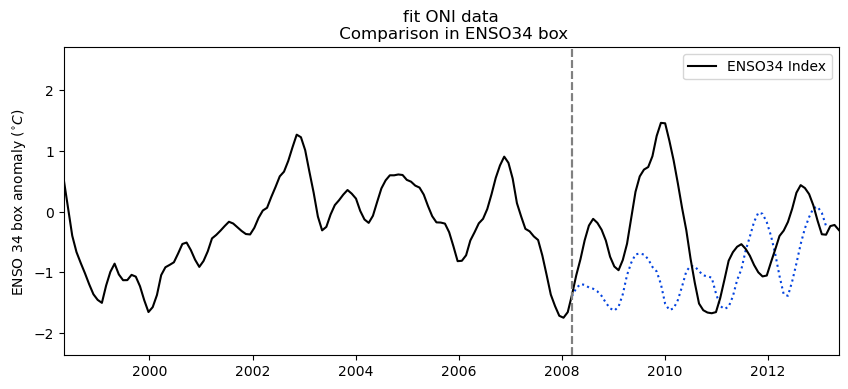

In [31]:
if modes_to_fit == "ONI":

    time_results = ds_oni.time.values[t_ind]

    plt.figure(figsize=(10, 4))

    # Test
    t = time_results[
        lags
        + train_length
        + validate_length
        - 2 : lags
        + train_length
        + validate_length
        + test_length
        - 2
    ]
    
    # plt.plot(t, driver._scaler.inverse_transform(output_sindy_np).mean(axis=1))

    
    ds_results = xarray_unstacked(
        driver._scaler.inverse_transform(output_sindy_np).T,
        t,
        lon_ragged_oni,
        lat_ragged_oni,
    )
    enso_component = enso_box_extract(ds_results, enso34_box)
    enso_spatial_mean = enso_component.mean(dim=["longitude", "latitude"])
    plt.plot(
        t,
        enso_spatial_mean,
        color="xkcd:blue",
        ls=":",
    )

    # Observations
    plt.plot(
        background_anomaly.time, background_anomaly, color="k", label="ENSO34 Index"
    )

    plt.xlim(
        time_results[lags],
        time_results[train_length + validate_length + test_length + lags],
    )
    plt.xlim(time_results[lags], None)
    plt.legend(ncols=3)
    plt.ylabel("ENSO 34 box anomaly ($^{\circ}C$)")
    plt.gca().axvline(time_results[train_length + lags - 2], ls="--", color="0.5")
    plt.gca().axvline(
        time_results[train_length + validate_length + lags - 2], ls="--", color="0.5"
    )
    plt.title(f"fit {modes_to_fit} data\n Comparison in ENSO34 box")

## Method 2: Unroll LSTM

Train a SHRED model to generate the LSTM

In [32]:
import models

In [33]:
# sensor_train_data_out = torch.tensor(
#     transformed_X[train_indices + lags][:, sensor_locations], dtype=torch.float32
# ).to(device)
# sensor_valid_data_out = torch.tensor(
#     transformed_X[valid_indices + lags][:, sensor_locations], dtype=torch.float32
# ).to(device)
# sensor_test_data_out = torch.tensor(
#     transformed_X[test_indices + lags][:, sensor_locations], dtype=torch.float32
# ).to(device)

# sensor_train_dataset = TimeSeriesDataset(train_data_in, sensor_train_data_out)
# sensor_valid_dataset = TimeSeriesDataset(valid_data_in, sensor_valid_data_out)
# sensor_test_dataset = TimeSeriesDataset(test_data_in, sensor_test_data_out)

sensor_forecaster = models.SHRED(
    num_sensors,
    num_sensors,
    hidden_size=32,
    hidden_layers=2,
    l1=100,
    l2=150,
    dropout=0.1,
).to(device)

sensor_val_errors = models.fit(
    sensor_forecaster,
    driver._train_data,
    driver._valid_data,
    batch_size=64,
    num_epochs=1000,
    verbose=True,
    lr=1e-3,
    patience=50,
)

Training epoch 1
Error tensor(nan, device='mps:0')
Training epoch 20
Error tensor(nan, device='mps:0')
Training epoch 40
Error tensor(nan, device='mps:0')
Training epoch 60
Error tensor(nan, device='mps:0')
Training epoch 80
Error tensor(nan, device='mps:0')
Training epoch 100
Error tensor(nan, device='mps:0')
Training epoch 120
Error tensor(nan, device='mps:0')
Training epoch 140
Error tensor(nan, device='mps:0')
Training epoch 160
Error tensor(nan, device='mps:0')
Training epoch 180
Error tensor(nan, device='mps:0')
Training epoch 200
Error tensor(nan, device='mps:0')
Training epoch 220
Error tensor(nan, device='mps:0')
Training epoch 240
Error tensor(nan, device='mps:0')
Training epoch 260
Error tensor(nan, device='mps:0')
Training epoch 280
Error tensor(nan, device='mps:0')
Training epoch 300
Error tensor(nan, device='mps:0')
Training epoch 320
Error tensor(nan, device='mps:0')
Training epoch 340
Error tensor(nan, device='mps:0')
Training epoch 360
Error tensor(nan, device='mps:0')

In [ ]:
test_dataset = driver._test_data
initialization = test_dataset.X[0:1].clone()

forecasted_sensors, forecasted_reconstructions = models.forecast(
    sensor_forecaster, driver._shred, test_dataset
)

In [ ]:
forecasted_long_sensors = np.zeros((forecasted_sensors.shape[0], len_space))
for i in range(len(forecasted_long_sensors)):
    forecasted_long_sensors[i, sensor_locations] = (
        forecasted_sensors[i].detach().cpu().numpy()
    )

scaled_forecast = driver._scaler.inverse_transform(
    forecasted_reconstructions.reshape(-1, len_space)
)
truths = np.zeros_like(scaled_forecast)
for i in range(len(forecasted_reconstructions)):
    truth = driver._scaler.inverse_transform(
        driver._train_data.Y[i : i + 1].detach().cpu().numpy()
    )
    truths[i] = truth.reshape(scaled_forecast.shape[1])

In [ ]:
for n in [0, 53, 67, 451, 312]:
    plt.plot(truths[:, n], "r")
    plt.plot(forecasted_long_sensors[:, n], color="k", ls="--")

In [ ]:
def plot_multiple_sensor_predictions(
    real_data,
    sindy_data,
    sensor_locations,
    sensor_indices,
    num_train=52,
    num_pred=250,
    rows=4,
    cols=4,
):
    """
    Plot the real data and SINDy-SHRED prediction for multiple sensors in a grid layout,
    normalizing each plot to (0,1) based on the min/max of the real data for that sensor.

    Args:
        real_data (np.array): The real SST data.
        sindy_data (np.array): The predicted data from SINDy-SHRED.
        sensor_locations (np.array): Sensor locations (indices) used in training.
        sensor_indices (list): Indices of the sensors to visualize.
        num_train (int): Number of training data points (default is 52).
        num_pred (int): Number of prediction data points (default is 250).
        rows (int): Number of rows in the grid layout.
        cols (int): Number of columns in the grid layout.

    Returns:
        None. Displays and saves the plot.
    """
    num_sensors = len(sensor_indices)
    fig, axes = plt.subplots(
        rows, cols, figsize=(3 * cols, 2 * rows), sharex=True, sharey=True
    )
    axes = axes.flatten()

    for i, sensor_idx in enumerate(sensor_indices):
        if i >= rows * cols:
            break
        sensor = sensor_locations[sensor_idx]
        # Real data for the training + prediction period
        sensor_real_data = real_data[: num_train + num_pred, sensor]
        # SINDy-SHRED prediction for the prediction period
        sensor_pred_data = sindy_data[num_train : num_train + num_pred, sensor]

        # Normalize both real and predicted data to (0,1) based on real data min/max
        min_val = np.min(sensor_real_data)
        max_val = np.max(sensor_real_data)
        if max_val - min_val == 0:
            # Avoid division by zero; plot as zeros
            norm_real = np.zeros_like(sensor_real_data)
            norm_pred = np.zeros_like(sensor_pred_data)
        else:
            norm_real = (sensor_real_data - min_val) / (max_val - min_val)
            norm_pred = (sensor_pred_data - min_val) / (max_val - min_val)

        axes[i].plot(
            np.arange(num_train + num_pred),
            norm_real,
            color="blue",
            linewidth=2,
            label="Real Data",
        )
        axes[i].plot(
            np.arange(num_train, num_train + num_pred),
            norm_pred,
            color="red",
            linestyle="--",
            linewidth=2,
            label="SINDy-SHRED",
        )
        axes[i].set_title(f"Sensor {sensor_idx}", fontsize=12)
        axes[i].tick_params(axis="both", which="major", labelsize=10)
        axes[i].axvline(x=num_train, color="gray", linestyle=":", linewidth=1.5)
        axes[i].set_ylim(0, 1)

    # Remove any unused subplots
    for i in range(num_sensors, rows * cols):
        fig.delaxes(axes[i])

    fig.text(0.5, 0.0, "Time (weeks)", ha="center", va="center", fontsize=16)
    # Add a common legend
    lines = [
        plt.Line2D([0], [0], color="blue", lw=2),
        plt.Line2D([0], [0], color="red", linestyle="--", lw=2),
    ]
    labels = ["Real Data", "SINDy-SHRED"]
    fig.legend(
        lines,
        labels,
        loc="upper right",
        bbox_to_anchor=(0.99, 0.945),
        fontsize=10,
        frameon=False,
    )

    plt.tight_layout()
    plt.savefig(
        "sensor_predictions_grid.pdf", format="pdf", bbox_inches="tight", dpi=300
    )
    plt.show()


# Example usage:
# Choose a set of sensor indices to visualize (e.g., 16 sensors)
num_sensors_to_plot = 16
sensor_indices = list(range(num_sensors_to_plot))
# Use the same sst_locs as above for sensor_locations
sensor_locations = np.random.randint(1, 40000, size=18)
plot_multiple_sensor_predictions(
    real_data=truths,
    sindy_data=scaled_forecast,
    sensor_locations=sensor_locations,
    sensor_indices=sensor_indices,
    num_train=52,
    num_pred=250,
    rows=4,
    cols=4,
)

Code from `sindy_shred.forecast`

Outstanding questions:

- Still unclear what `forecaster` is supposed to be.
- Doesn't match the SHRED

In [ ]:
test_dataset = driver._test_data

initial_in = test_dataset.X[0:1].clone()
vals = [
    initial_in[0, i, :].detach().cpu().clone().numpy()
    for i in range(test_dataset.X.shape[1])
]

In [ ]:
forecaster = sensor_forecaster
# t_forecast = np.arange(0, len(test_dataset.X[0]) * driver._dt, driver._dt)

for i in range(len(test_dataset.X)):
    scaled_output1, scaled_output2 = forecaster(initial_in)
    scaled_output1 = scaled_output1.detach().cpu().numpy()
    scaled_output2 = scaled_output2.detach().cpu().numpy()
    vals.append(
        np.concatenate(
            [
                scaled_output1.reshape(test_dataset.X.shape[2] // 2),
                scaled_output2.reshape(test_dataset.X.shape[2] // 2),
            ]
        )
    )
    temp = initial_in.clone()
    initial_in[0, :-1] = temp[0, 1:]
    initial_in[0, -1] = torch.tensor(np.concatenate([scaled_output1, scaled_output2]))